In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
from IPython.display import display

# Google Colab

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# DATA_PATH = '/content/drive/MyDrive/IFT6758B-Project/Milestone1/data/IFT6758_Data'
# PROJECT_PATH = '/content/drive/MyDrive/IFT6758B-Project/Milestone1'

# Local

In [4]:
DATA_PATH = '../data/IFT6758_Data'
PROJECT_PATH = '../../Milestone1/'

## Import previous functions

In [5]:
sys.path.append(PROJECT_PATH)
from features.tidy_data import tidy_data

## Simple Visualization

In [6]:
df = tidy_data(DATA_PATH, 2017, 'regular', 2017020273)
df

,game_id,homeTeam,awayTeam,periodType,period,periodTime,team,eventType,x_coordinate,y_coordinate,goal_location,shooter,goalie,shotType,emptyNet,strength
0,2017020273,EDM,VGK,REGULAR,1,03:49,EDM,Shot,86.0,15.0,Left,Darnell Nurse,Maxime Lagace,Wrist Shot,None,None
1,2017020273,EDM,VGK,REGULAR,1,04:40,VGK,Shot,-73.0,23.0,Right,David Perron,Cam Talbot,Wrist Shot,None,None
2,2017020273,EDM,VGK,REGULAR,1,04:51,VGK,Shot,-67.0,-13.0,Right,David Perron,Cam Talbot,Slap Shot,None,None
3,2017020273,EDM,VGK,REGULAR,1,06:28,EDM,Goal,79.0,3.0,Left,Oscar Klefbom,Maxime Lagace,Wrist Shot,False,SHG
4,2017020273,EDM,VGK,REGULAR,1,08:16,EDM,Shot,52.0,-12.0,Left,Adam Larsson,Maxime Lagace,Wrist Shot,None,None
5,2017020273,EDM,VGK,REGULAR,1,08:22,EDM,Shot,37.0,27.0,Left,Kris Russell,Maxime Lagace,Snap Shot,None,None
6,2017020273,EDM,VGK,REGULAR,1,08:53,VGK,Shot,-72.0,-8.0,Right,Brad Hunt,Cam Talbot,Snap Shot,None,None
7,2017020273,EDM,VGK,REGULAR,1,10:59,EDM,Shot,39.0,-20.0,Left,Matt Benning,Maxime Lagace,Slap Shot,None,None
8,2017020273,EDM,VGK,REGULAR,1,11:34,VGK,Shot,-40.0,-15.0,Right,Cody Eakin,Cam Talbot,Wrist Shot,None,None
9,2017020273,EDM,VGK,REGULAR,1,12:04,EDM,Shot,64.0,-12.0,Left,Yohann Auvitu,Maxime Lagace,Wrist Shot,None,None


In [7]:
json_regex = re.compile(r"(.*)\.json")

def season_integration(path, year, season) -> pd.DataFrame:
    df = pd.DataFrame()
    season_path = os.path.join(path, str(year), season)
    i = 0

    for file_path in os.listdir(season_path):
        match = re.match(json_regex, file_path)
        # print(match.group(1))
        # print(i)
        # i += 1
        if match:
            game_id = match.group(1)
            # print(game_id)
            # break
            game_df = tidy_data(path, year, season, game_id)
            # display(game_df)
            # break
            df = pd.concat([df, game_df], ignore_index=True)
            # display(df)
            # break

    return df

# df = season_integration(DATA_PATH, 2016, 'regular')
# df.reset_index(drop=True, inplace=True)

def year_integration(path, year) -> pd.DataFrame:
    df = pd.DataFrame()
    for season in ['regular', 'playoffs']:
        season_df = season_integration(path, year, season)
        df = pd.concat([df, season_df], ignore_index=True)
    return df


### Question 1
Produce a figure comparing the shot types over all teams (i.e. just aggregate all of the shots), in a season of your choosing. Overlay the number of goals overtop the number of shots. 
What appears to be the most dangerous type of shot? The most common type of shot? Why did you choose this figure? Add this figure and discussion to your blog post.

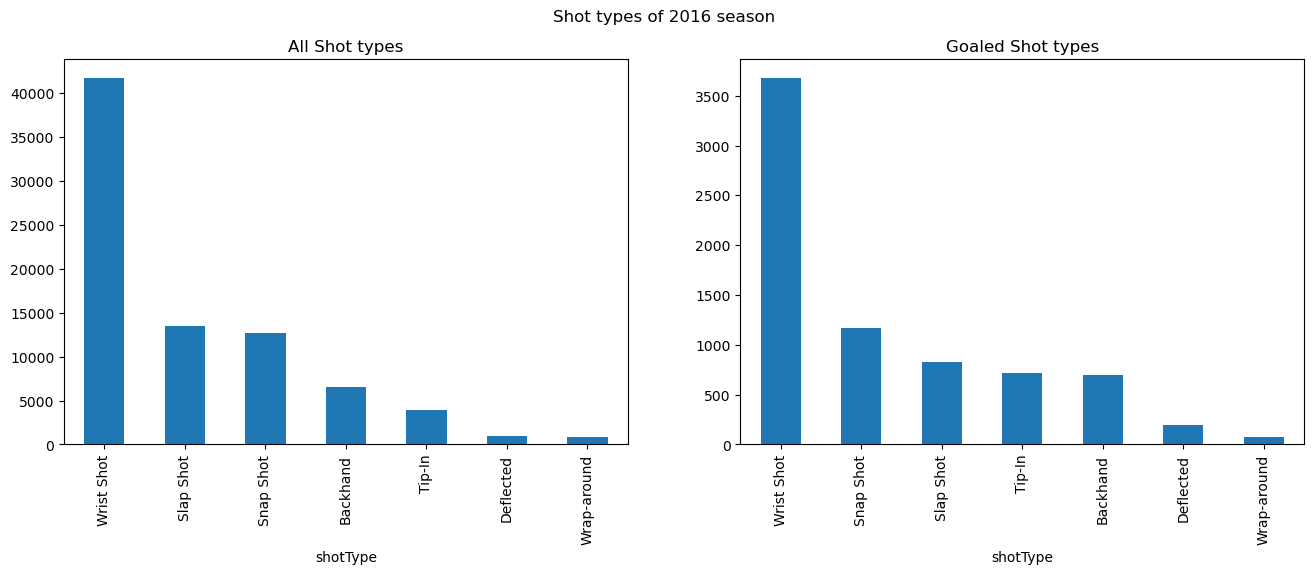

In [8]:
year = 2016
df = year_integration(DATA_PATH, year)
df.reset_index(drop=True, inplace=True)
df_goal = df[df['eventType'] == 'Goal'].reset_index(drop=True)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
df['shotType'].value_counts().plot(kind='bar')
plt.title('All Shot types')
plt.subplot(1, 2, 2)
df_goal['shotType'].value_counts().plot(kind='bar')
plt.title('Goaled Shot types')
plt.suptitle('Shot types of {} season'.format(year))
plt.show()


### Question 2
What is the relationship between the distance a shot was taken and the chance it was a goal? Produce a figure for each season between 2018-19 to 2020-21 to answer this, 
and add it to your blog post along with a couple of sentences describing your figure. Has there been much change over the past three seasons? Why did you choose this figure?

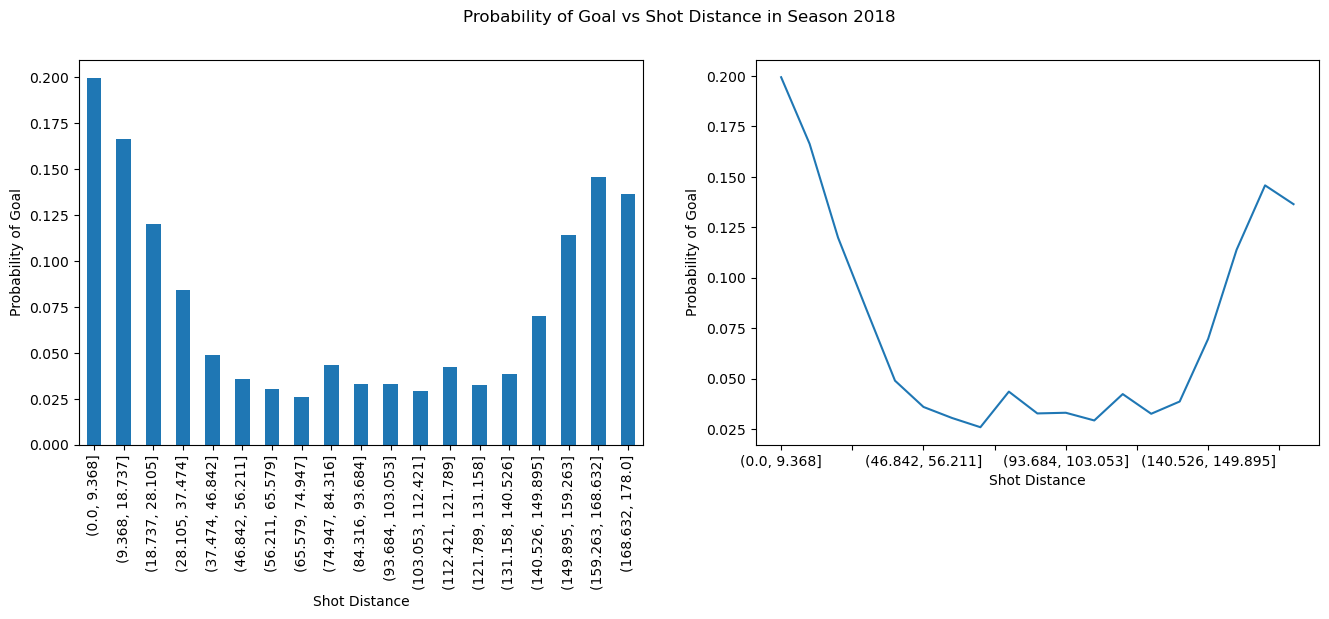

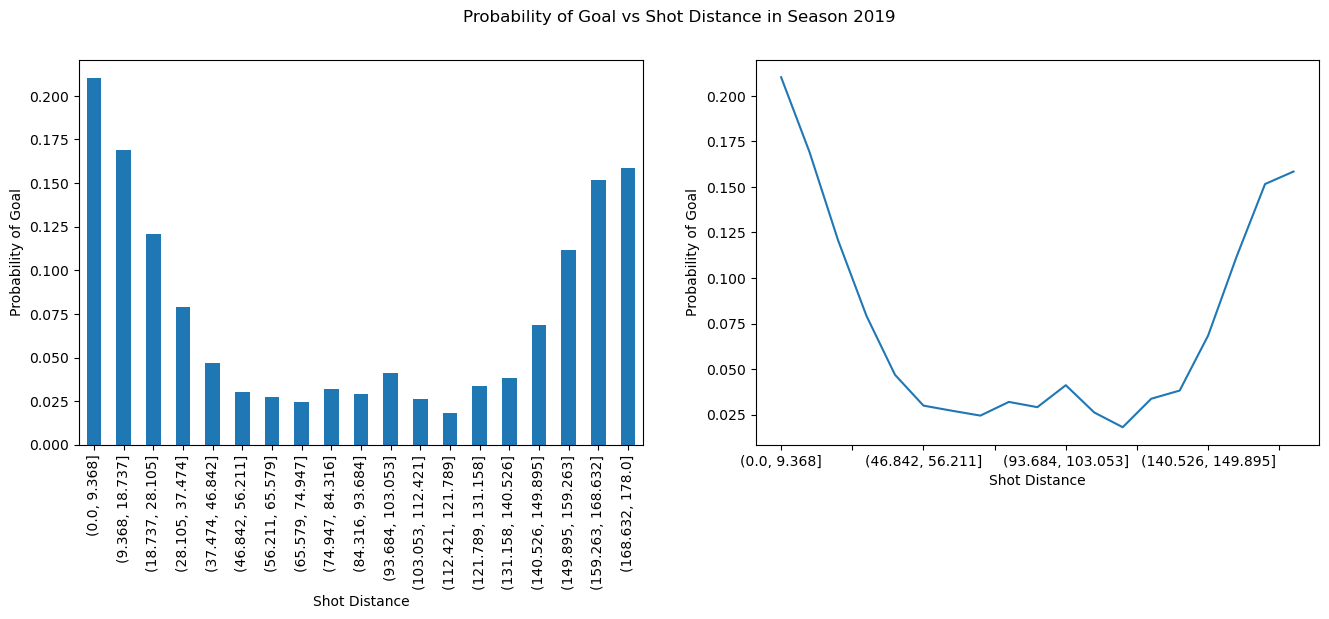

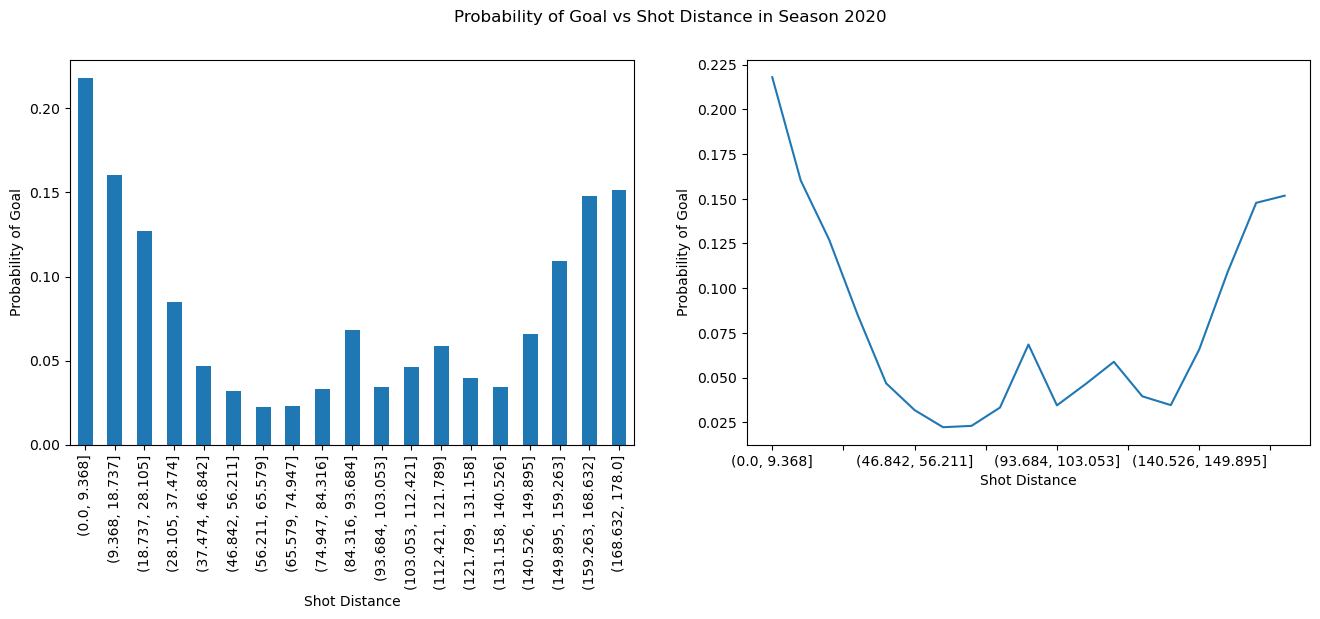

In [9]:
def calculate_shot_distance(df):
    if df['goal_location'] == 'Left':
        # calculate distance to (-89, 0)
        return np.sqrt((df['x_coordinate'] - (-89))**2 + (df['y_coordinate'] - 0)**2)
    elif df['goal_location'] == 'Right':
        # calculate distance to (89, 0)
        return np.sqrt((df['x_coordinate'] - 89)**2 + (df['y_coordinate'] - 0)**2)
    
# df['shotDistance'] = df.apply(calculate_shot_distance, axis=1)

# max_distance = df['shotDistance'].max()
max_distance = np.sqrt((89*2)**2 + 0**2)
# min_distance = df['shotDistance'].min()
min_distance = 0

# divide the distance into 20 bins
bins = np.linspace(min_distance, max_distance, 20)

def calculate_probability_distance(start_year, end_year):
    num_year = end_year - start_year + 1
    for i in range(num_year):
        year = start_year + i
        df = year_integration(DATA_PATH, year)
        df['shotDistance'] = df.apply(calculate_shot_distance, axis=1)
        df['shotDistanceBin'] = pd.cut(df['shotDistance'], bins=bins)
        df_shot = df[df['eventType'] == 'Shot'].reset_index(drop=True)
        df_goal = df[df['eventType'] == 'Goal'].reset_index(drop=True)
        df_goal_count = df_goal.groupby('shotDistanceBin').count()['eventType']
        df_total_count = df.groupby('shotDistanceBin').count()['eventType']
        df_goal_prob = df_goal_count / df_total_count
        plt.figure(figsize=(16, 5))
        plt.suptitle('Probability of Goal vs Shot Distance in Season {}'.format(year))
        plt.subplot(1, 2, 1)
        df_goal_prob.plot(kind='bar')
        plt.xlabel('Shot Distance')
        plt.ylabel('Probability of Goal')
        plt.subplot(1, 2, 2)
        df_goal_prob.plot()
        plt.xlabel('Shot Distance')
        plt.ylabel('Probability of Goal')
        plt.show()

calculate_probability_distance(2018, 2020)


### Question 3
Combine the information from the previous sections to produce a figure that shows the goal percentage (# goals / # shots) as a function of both distance from the net, and the category of shot types (you can pick a single season of your choice). 
Briefly discuss your findings; e.g. what might be the most dangerous types of shots?

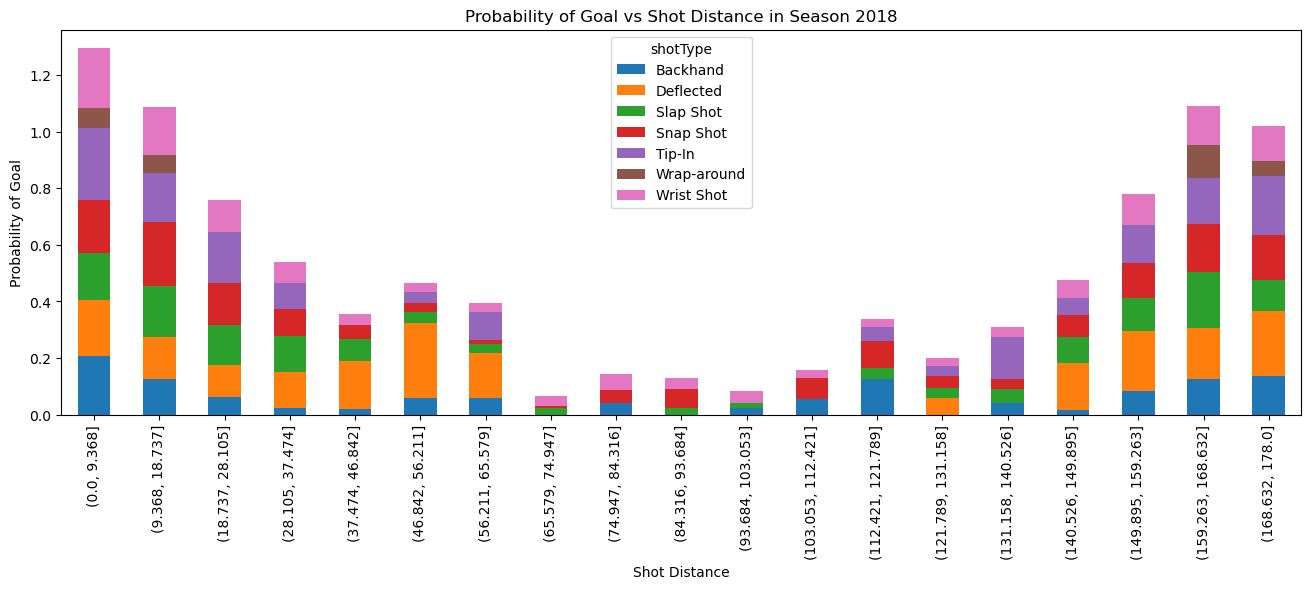

In [12]:
def calculate_probability_distance_shottypes(year):
    df = year_integration(DATA_PATH, year)
    df['shotDistance'] = df.apply(calculate_shot_distance, axis=1)
    df['shotDistanceBin'] = pd.cut(df['shotDistance'], bins=bins)
    df_shot = df[df['eventType'] == 'Shot'].reset_index(drop=True)
    df_goal = df[df['eventType'] == 'Goal'].reset_index(drop=True)
    df_goal_count = df_goal.groupby(['shotDistanceBin', 'shotType']).count()['eventType']
    df_total_count = df.groupby(['shotDistanceBin', 'shotType']).count()['eventType']
    df_goal_prob = df_goal_count / df_total_count
    df_goal_prob = df_goal_prob.unstack()
    df_goal_prob.plot(kind='bar', stacked=True, figsize=(16, 5))
    plt.xlabel('Shot Distance')
    plt.ylabel('Probability of Goal')
    plt.title('Probability of Goal vs Shot Distance in Season {}'.format(year))
    plt.show()
    



calculate_probability_distance_shottypes(2018)